In [34]:
# Importar librerías necesarias
import kagglehub
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt

In [37]:
# Descargar y cargar el dataset
path = kagglehub.dataset_download("mnassrib/jena-climate")
data_file = f"{path}/jena_climate_2009_2016.csv"
data = pd.read_csv(data_file)

In [38]:
# Preprocesar el dataset
# Eliminar la columna de fecha y hora si es la primera columna
data = data.drop(columns=[data.columns[0]])

# Reemplazar valores faltantes con la media de cada columna
data = data.apply(pd.to_numeric, errors='coerce')  # Asegura que todas las columnas sean numéricas
data = data.fillna(data.mean())

# Seleccionar entradas y salidas para el modelo
inputs, outputs = data.iloc[:, 1:], data.iloc[:, 1]  # Ajusta si la salida es diferente
X = inputs.to_numpy()
y = outputs.to_numpy()

In [40]:
# Normalizar los datos de entrenamiento
train_size = int(0.5 * len(X))
mean = X[:train_size].mean(axis=0)
std = X[:train_size].std(axis=0)
X = (X - mean) / std

In [41]:
# Configuración de la secuencia y los lotes
sequence_length = 120  # Últimas 120 horas para predecir 24 horas adelante
sampling_rate = 6
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [42]:
# Crear conjuntos de datos de entrenamiento, validación y prueba
train_dataset = timeseries_dataset_from_array(
    X[:-delay], targets=y[delay:], sequence_length=sequence_length,
    sampling_rate=sampling_rate, batch_size=batch_size, start_index=0, end_index=train_size
)
val_dataset = timeseries_dataset_from_array(
    X[:-delay], targets=y[delay:], sequence_length=sequence_length,
    sampling_rate=sampling_rate, batch_size=batch_size, start_index=train_size, end_index=train_size * 3 // 2
)
test_dataset = timeseries_dataset_from_array(
    X[:-delay], targets=y[delay:], sequence_length=sequence_length,
    sampling_rate=sampling_rate, batch_size=batch_size, start_index=train_size * 3 // 2
)

In [46]:
# Definir el modelo LSTM
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X.shape[-1]), return_sequences=True),
    LSTM(64),
    Dense(1)
])


model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
# Entrenar el modelo con 10 épocas
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 574s 698ms/step - loss: 29.3478 - mae: 4.0791 - val_loss: 30.0491 - val_mae: 4.4878
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 620s 695ms/step - loss: 13.5769 - mae: 2.8328 - val_loss: 24.6480 - val_mae: 4.0256
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 573s 699ms/step - loss: 12.4882 - mae: 2.7009 - val_loss: 23.2989 - val_mae: 3.9228
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 578s 706ms/step - loss: 11.6712 - mae: 2.6379 - val_loss: 23.5175 - val_mae: 3.9205
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 574s 701ms/step - loss: 11.2664 - mae: 2.5949 - val_loss: 22.4582 - val_mae: 3.8205
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 584s 714ms/step - loss: 10.9402 - mae: 2.5545 - val_loss: 19.3027 - val_mae: 3.5215
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 579s 707ms/step - loss: 10.7551 - mae: 2.5089 - val_loss: 20.8485 - val_mae: 3.6791
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 625s 710ms/step - loss: 10.4332 - mae: 2.4967 - val_loss: 19.6179 - val_mae: 3.5474
Epoch 9/

405/405 ━━━━━━━━━━━━━━━━━━━━ 105s 260ms/step - loss: 22.2780 - mae: 3.6884
MAE en el conjunto de prueba: 3.93


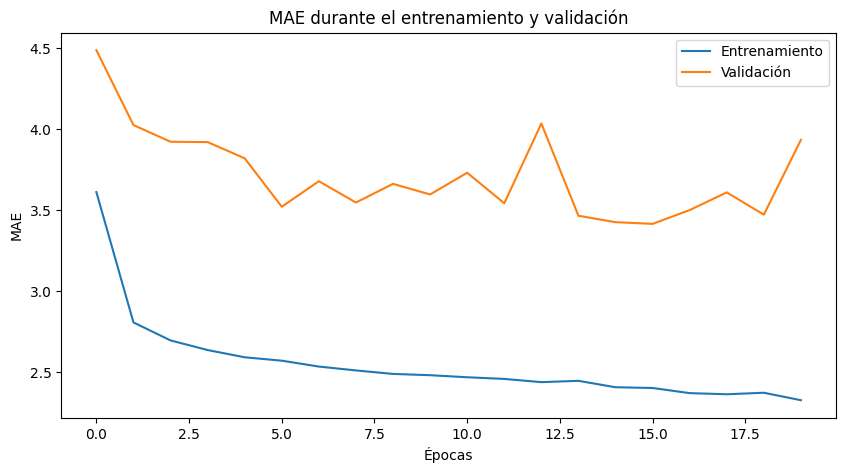

In [48]:
# Evaluar el modelo en el conjunto de prueba
test_mae = model.evaluate(test_dataset)[1]
print(f"MAE en el conjunto de prueba: {test_mae:.2f}")

# Graficar el rendimiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('MAE durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()